In [2]:
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity as cos_sim_sk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
from torch.nn.functional import cosine_similarity as cossim_pt
from typing import Sequence, Dict, Tuple, List, Optional, Union

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
# Import GPT-2 Model and Tokenizer
from transformers import GPT2Model, GPT2Tokenizer
gpt2 = GPT2Model.from_pretrained('gpt2')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
embeddings_gpt2 = gpt2.wte.weight.detach().numpy()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# Generate sample data
N = 30

# Create vectors
d1 = np.random.randn(N) + 1
d2 = d1 + np.random.randn(N)
d3 = -d1 + np.random.randn(N)

In [6]:
# Caluclate the cosine similarity manually
num = sum(d1 * d2)
den = np.sqrt(sum(d1**2)) * np.sqrt(sum(d2**2))
cos_sim = num / den
cos_sim.item()

0.8148541068728758

In [7]:
# Calculate the cosine similarity usining sklrean
cos_sim_sk = cos_sim_sk(d1.reshape(1,-1), d2.reshape(1,-1))
cos_sim_sk.item()

0.8148541068728757

In [8]:

# Ensure d1 and d2 are numpy arrays before converting to tensors
if not isinstance(d1, torch.Tensor):
    d1 = torch.from_numpy(d1)
if not isinstance(d2, torch.Tensor):
    d2 = torch.from_numpy(d2)

cos_sim_pt = cossim_pt(d1.unsqueeze(dim=0), d2.unsqueeze(dim=0))
cos_sim_pt.detach().item()

0.8148541068728757

In [9]:
def tokenize_word(target_word: str)->Sequence[str]:
  target_word_id = tokenizer_gpt2.encode(target_word)
  target_word_tokens = [tokenizer_gpt2.decode(id) for id in target_word_id]

  return target_word_tokens

In [10]:
target_word = 'cosmic'
print(f"Tokens for word '{target_word}' in GPT-2 are {tokenize_word(target_word)}")

Tokens for word 'cosmic' in GPT-2 are ['cos', 'mic']


In [11]:
target_word = 'cos'
v1 = embeddings_gpt2[tokenizer_gpt2.encode(target_word)]
for s in ['mic','ine']:
  v2 = embeddings_gpt2[tokenizer_gpt2.encode(s)]
  similarity_score = cossim_pt(torch.from_numpy(v1), torch.from_numpy(v2))
  print(f"Cosine similarity between '{target_word}' and '{s}' is {similarity_score.detach().item()}")

Cosine similarity between 'cos' and 'mic' is 0.24418646097183228
Cosine similarity between 'cos' and 'ine' is 0.1791212260723114


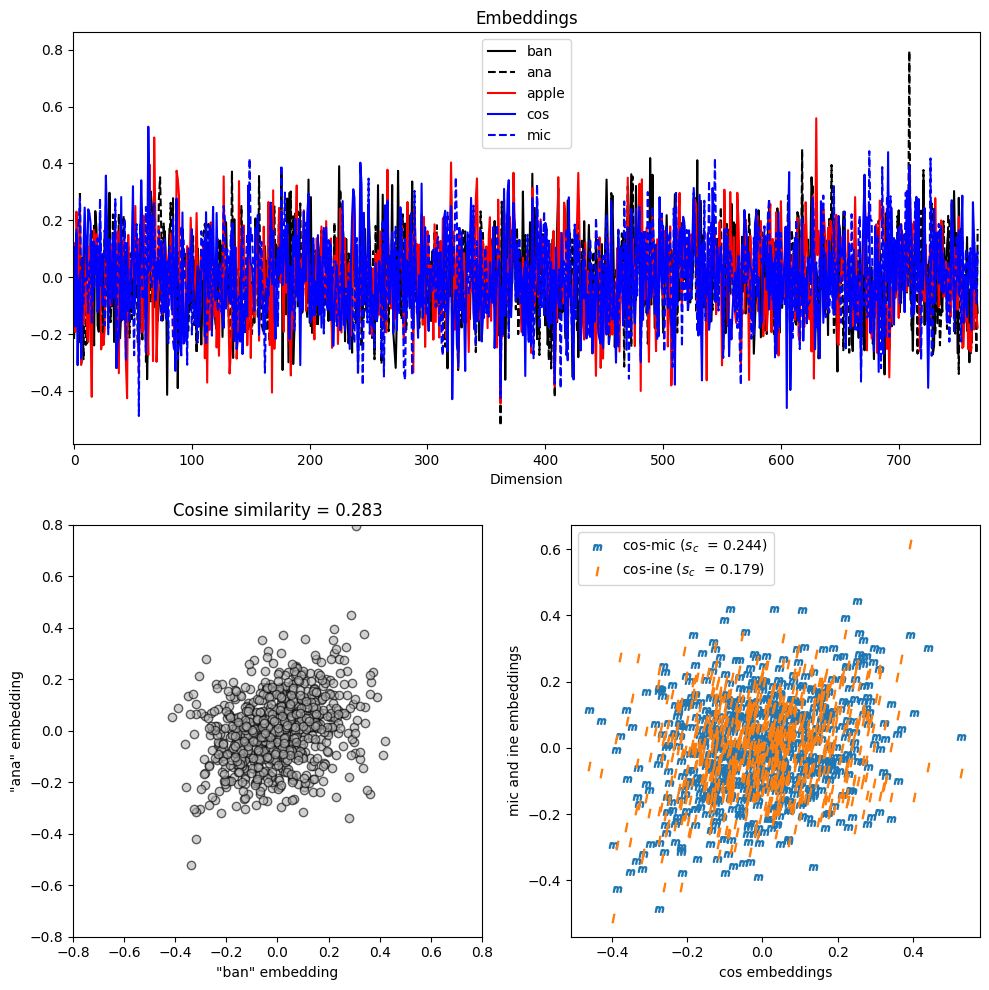

In [12]:
# words of interest
word1 = 'banana'
word2 = 'apple'
word3 = 'cosmic'

# Setup the figure subplots
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

#----------------------------Plot 1--------------------------------------
# plot the embeddings by dimension
colors = 'krb'
linestyles = ['-','--','-.',':']
for idx,word in enumerate([word1,word2,word3]):
  wordidx = tokenizer_gpt2.encode(word)
  for j in range(len(wordidx)):
    ax1.plot(embeddings_gpt2[wordidx[j],:],linestyle=linestyles[j],color=colors[idx],label=tokenizer_gpt2.decode(wordidx[j]))

ax1.set(xlabel='Dimension',title='Embeddings',xlim=[-1,embeddings_gpt2.shape[1]+1])
ax1.legend()

#----------------------------Plot 2--------------------------------------
# cosine similarity between 'ban' and 'ana'
v1 = embeddings_gpt2[tokenizer_gpt2.encode('ban')]
v2 = embeddings_gpt2[tokenizer_gpt2.encode('ana')]
cossim = np.sum(v1*v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

# plot the embeddings by each other
ax2.plot(v1,v2,'ko',markerfacecolor=[.7,.7,.7,.6])
ax2.set(xlim=[-.8,.8],ylim=[-.8,.8],xlabel='"ban" embedding',ylabel='"ana" embedding',
        title=f'Cosine similarity = {cossim:.3f}')


#---------------------------Plot 3------------------------------------
for s in ['mic','ine']:
  v1_np = embeddings_gpt2[tokenizer_gpt2.encode('cos')].flatten() # v1 as 1D numpy array
  v2_np = embeddings_gpt2[tokenizer_gpt2.encode(s)].flatten() # v2 as 1D numpy array

  # Convert to PyTorch tensors and unsqueeze to make them 2D (1, embedding_dim)
  v1_tensor = torch.from_numpy(v1_np).unsqueeze(dim=0)
  v2_tensor = torch.from_numpy(v2_np).unsqueeze(dim=0)

  similarity_score = cossim_pt(v1_tensor, v2_tensor)

  # plot (using the original 1D numpy array for scatter plot as it expects 1D data)
  ax3.scatter(v1_np, v2_np, marker=f'${s[0]}$', label=f'cos-{s} ($s_c$  = {similarity_score.item():.3f})')
  ax3.set(xlabel='cos embeddings', ylabel='mic and ine embeddings')

ax3.legend()

plt.tight_layout()
plt.show()

In [39]:
# Find token with similar embeddings
target_word = 'apple'
target_word_embeddings = embeddings_gpt2[tokenizer_gpt2.encode(target_word)]
target_word_embeddings_norm = np.linalg.norm(target_word_embeddings)

cos_similar_array = np.zeros(embeddings_gpt2.shape[0])
for idx, v in enumerate(embeddings_gpt2):
  cos_similar_array[idx] = np.sum(target_word_embeddings*v)/(target_word_embeddings_norm*np.linalg.norm(v))


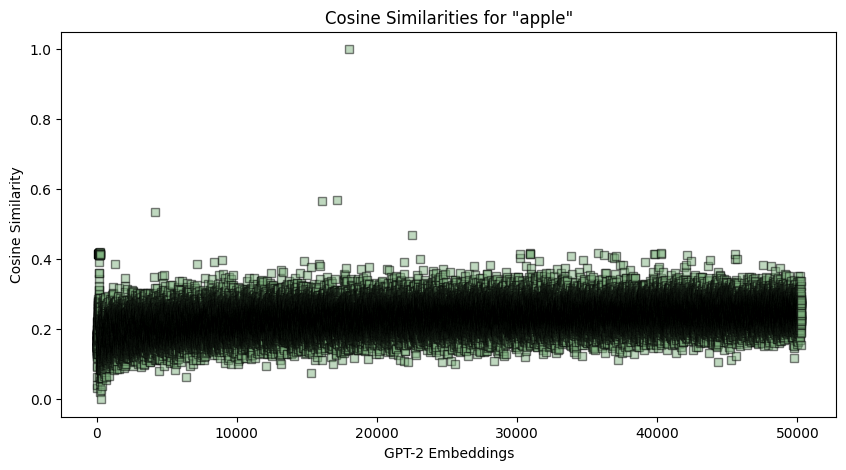

In [40]:
# Visualize the results
fig = plt.figure(figsize=(10,5))
plt.plot(cos_similar_array, 'ks', markerfacecolor=[.5,.7,.5], alpha=0.5)
plt.gca().set(xlabel='GPT-2 Embeddings', ylabel='Cosine Similarity', title=f'Cosine Similarities for "{target_word}"')

plt.show()

In [41]:
num_similar_tokens = 20
# Get the indices of the top N most similar tokens
top_indices = np.argsort(cos_similar_array)[::-1][:num_similar_tokens]

print(f"Top {num_similar_tokens} most similar tokens to '{target_word}':")
print("-"*30)
for idx in top_indices:
  token = tokenizer_gpt2.decode(idx)
  similarity = cos_similar_array[idx]
  print(f"Token: '{token:>12}', Similarity: {similarity:>4.2f}")

Top 20 most similar tokens to 'apple':
------------------------------
Token: '       apple', Similarity: 1.00
Token: '       apple', Similarity: 0.57
Token: '       Apple', Similarity: 0.57
Token: '       Apple', Similarity: 0.53
Token: '      apples', Similarity: 0.47
Token: '           ', Similarity: 0.42
Token: '            ', Similarity: 0.42
Token: '         iOS', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: 'InstoreAndOnline', Similarity: 0.42
Token: '           �', Similarity: 0.42
Token: '           �', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: ' reportprint', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: '           ', Similarity: 0.42
Token: '           �', Similarity: 0.42


In [42]:
target_word = 'apple'
target_word_embeddings = embeddings_gpt2[tokenizer_gpt2.encode(target_word)]
target_word_embeddings_normalized = target_word_embeddings/np.linalg.norm(target_word_embeddings)

# Reshape the norms to (50257, 1) to enable correct broadcasting
embeddings_gpt2_normalized = embeddings_gpt2 / np.linalg.norm(embeddings_gpt2, axis=1)[:,np.newaxis]

cosine_similarity_array = target_word_embeddings_normalized @ embeddings_gpt2_normalized.T

print(f"Shape of cosine_similarity_array: {cosine_similarity_array.shape}")
#

Shape of cosine_similarity_array: (1, 50257)


In [45]:
corr_coef = np.corrcoef(cosine_similarity_array.squeeze(), cos_similar_array)[0,1]
print(f"Correlation coefficient: {corr_coef}")

Correlation coefficient: 0.9999999999998328


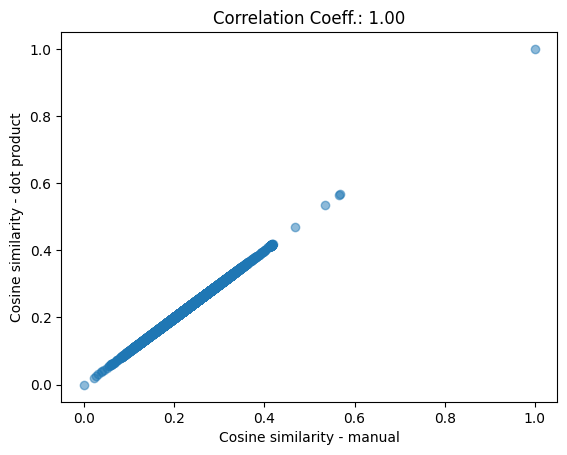

In [47]:
plt.scatter(cosine_similarity_array.squeeze(), cos_similar_array, alpha=0.5)
plt.gca().set(xlabel='Cosine similarity - manual', ylabel='Cosine similarity - dot product', title=f'Correlation Coeff.: {corr_coef:0.2f}')
plt.show()